# Try some organization schema for syllable use heatmaps

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from toolz import reduce
from operator import add
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster
from scipy.spatial.distance import squareform, pdist
from aging.plotting import figure, PlotConfig, save_factory, format_plots

In [4]:
format_plots()

In [189]:
df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_males_relabeled_usage_matrix_v00.parquet').astype(float).sort_index(axis='columns')
# df = df.iloc[:, :50]
mask = df.quantile(0.95) > 0.015
mask = mask[mask].index

In [191]:
df = df[mask]

In [192]:
# Z = linkage(df.T, 'ward')
Z = linkage(df.T, 'complete')
order = leaves_list(Z)

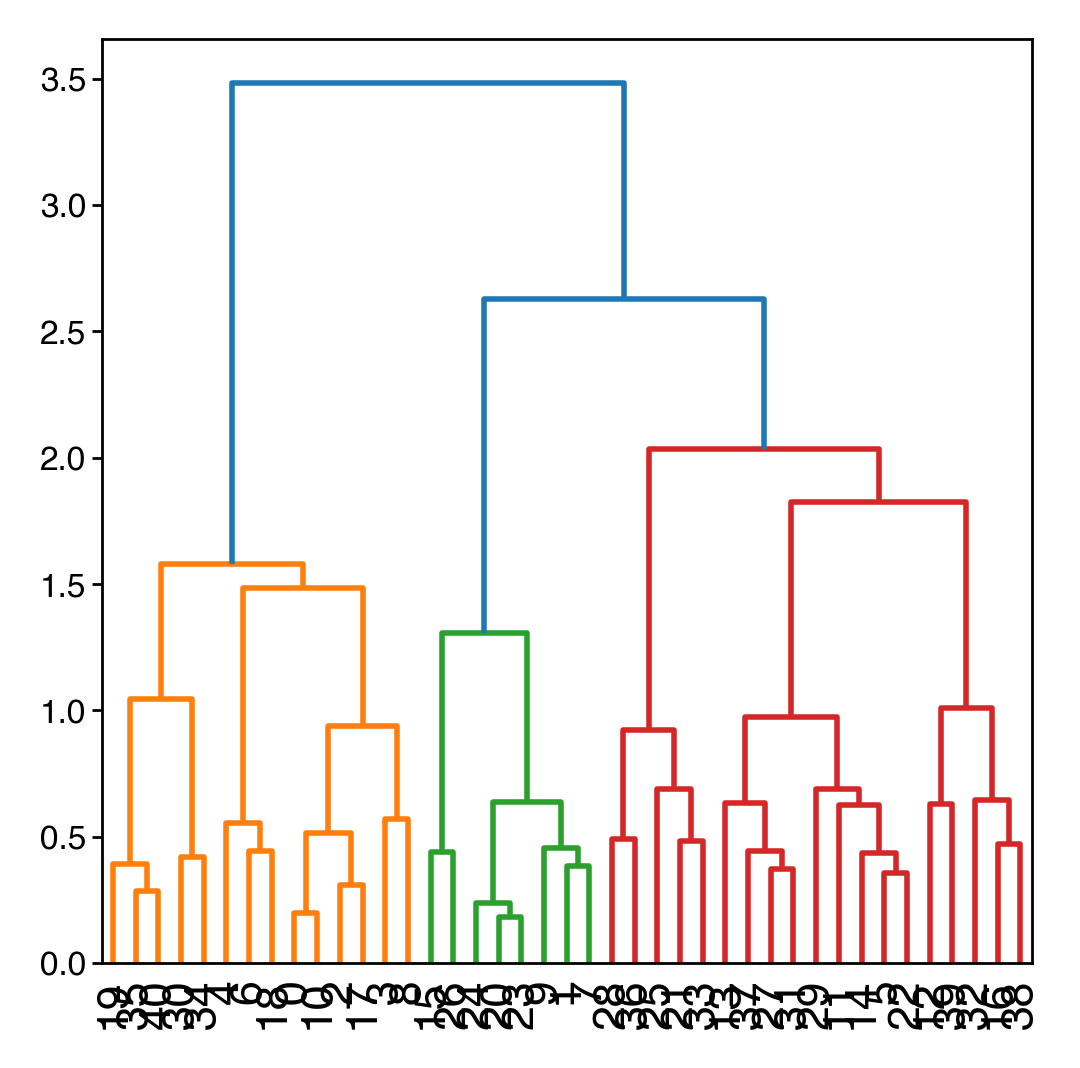

In [342]:
dists = pdist(df.T, metric='correlation')
Z = linkage(dists, 'ward')
dendrogram(Z);

In [382]:
cluster_labels = fcluster(Z, 1.5, criterion='distance')

In [383]:
cluster_labels

array([2, 3, 2, 2, 2, 5, 2, 3, 2, 3, 2, 5, 6, 5, 5, 3, 6, 2, 2, 1, 3, 4,
       5, 3, 3, 4, 3, 5, 4, 5, 1, 5, 6, 4, 1, 1, 4, 5, 6, 6, 1],
      dtype=int32)

In [384]:
df_with_cluster = df.T
# df_with_cluster = df_with_cluster.set_index([pd.Index(cluster_labels, name='labels'), pd.Index(df_with_cluster.index, name="syllables")])

In [385]:
# re-rank labels by usage
cluster_avgs = df_with_cluster.groupby(cluster_labels).mean().T.mean()
re_ordered = cluster_avgs.sort_values(ascending=False)
re_ordered

2    0.036111
3    0.022882
5    0.016452
6    0.012757
4    0.011363
1    0.009786
dtype: float64

In [386]:
new_map_order = dict(map(reversed, enumerate(re_ordered.index)))

In [387]:
df_with_cluster = df_with_cluster.set_index([pd.Index(cluster_labels, name='labels').map(new_map_order), pd.Index(df_with_cluster.index, name="syllables")])

In [393]:
within_clust_org = {}
for i, (l, _df) in enumerate(df_with_cluster.groupby('labels')):
    syllable_order = _df.T.quantile(0.75).index.get_level_values('syllables')
    if i % 2 == 1:
        within_clust_org[l] = list(syllable_order)
    else:
        within_clust_org[l] = list(syllable_order)[::-1]

In [394]:
plt_order = reduce(add, within_clust_org.values())

In [395]:
plt_df = df[plt_order]

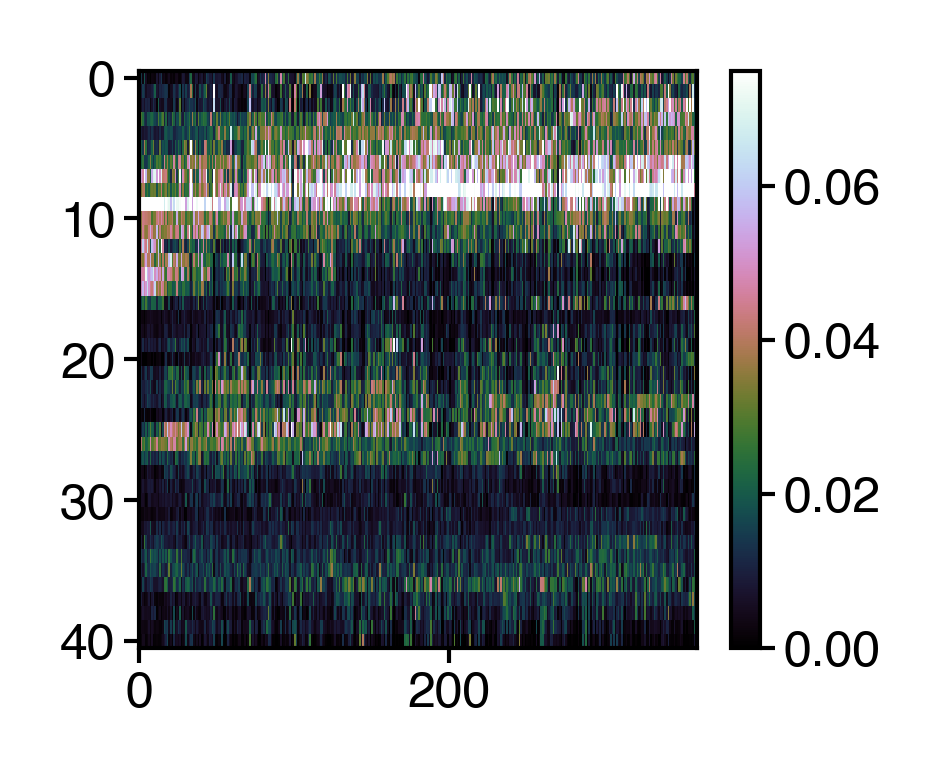

In [396]:
figure(1.5, 1.25)
plt.imshow(plt_df.T, vmax=0.075, cmap='cubehelix', aspect='auto', interpolation='none')
plt.colorbar()

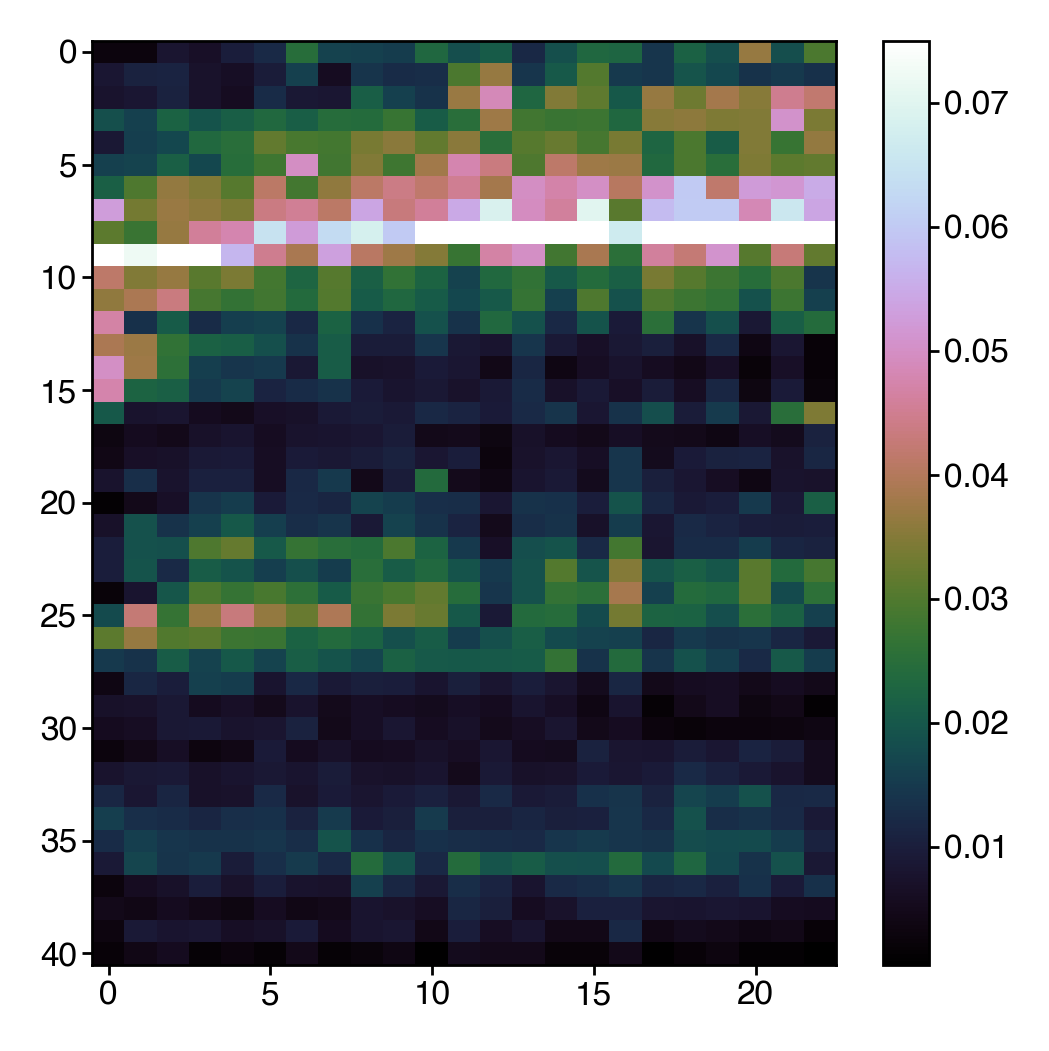

In [397]:
plt.imshow(df.groupby('age').median()[plt_order].T, vmax=0.075, cmap='cubehelix', aspect='auto', interpolation='none')
plt.colorbar()

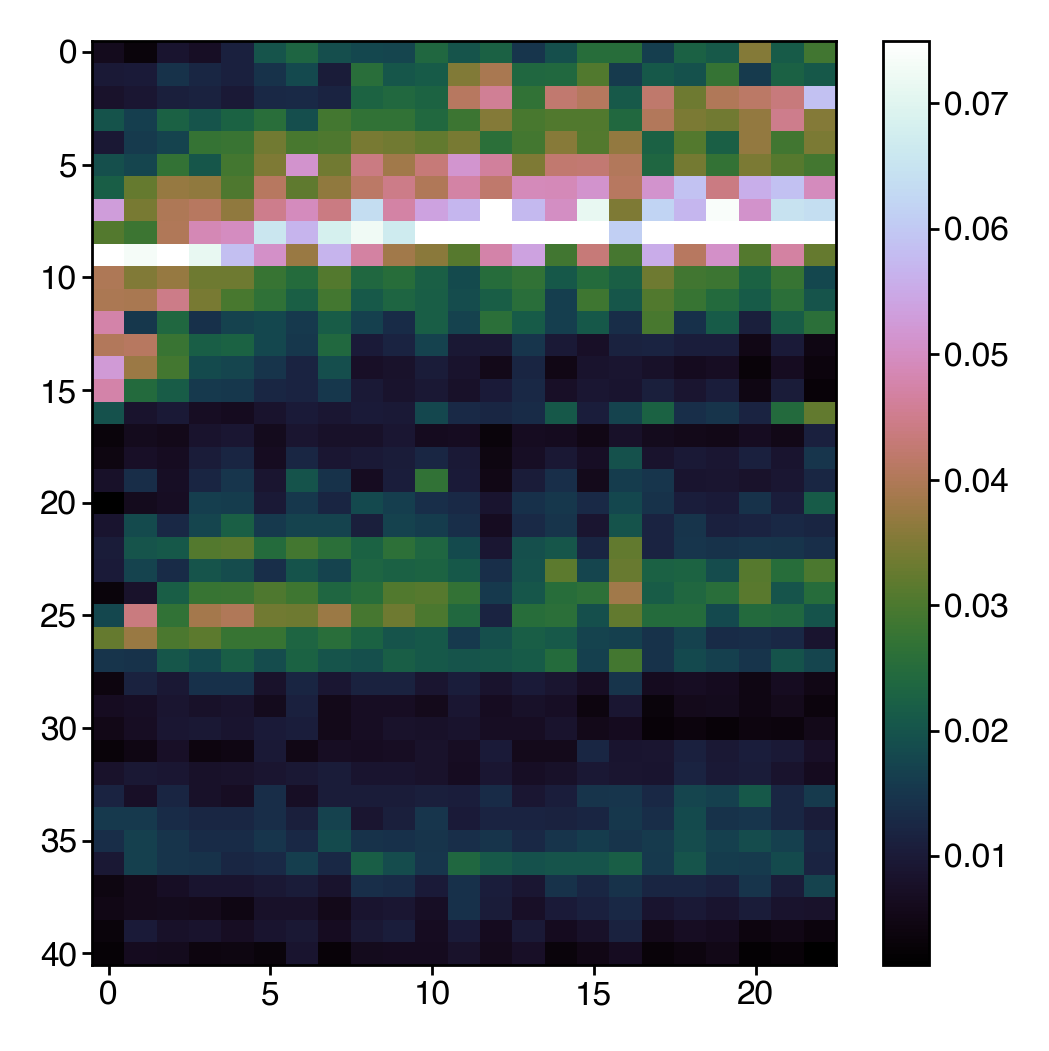

In [398]:
plt.imshow(df.groupby('age').mean()[plt_order].T, vmax=0.075, cmap='cubehelix', aspect='auto', interpolation='none')
plt.colorbar()